In [1]:
import json
import numpy as np
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 64,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
throughputs_file = '../oracle_throughputs.json'
with open(throughputs_file, 'r') as f:
    throughputs = json.load(f)

In [3]:
model_map = {
    'ResNet-18 (batch size 64)': 'ResNet-18',
    'ResNet-50 (batch size 128)': 'ResNet-50',
    'Transformer (batch size 64)': 'Transformer',
    'LM (batch size 20)': 'LSTM',
    'A3C': 'A3C',
    'CycleGAN': 'CycleGAN'
}

In [4]:
models = sorted(model_map.keys())
num_jobs = len(models)
throughputs_matrix = np.zeros((num_jobs, num_jobs), dtype=np.float32)

In [5]:
isolated_throughputs = {}
for model in models:
    isolated_throughputs[model] = throughputs['p100'][model]['null']

In [6]:
for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if model2 == 'null':
            continue
        elif j < i:
            throughputs_matrix[i][j] = np.nan
        else:
            colocated_throughputs = throughputs['p100'][model1][model2]
            throughputs_matrix[i][j] += colocated_throughputs[0] / isolated_throughputs[model1]
            throughputs_matrix[i][j] += colocated_throughputs[1] / isolated_throughputs[model2]
            throughputs_matrix[i][j] = round(throughputs_matrix[i][j], 2)

In [7]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    plt.set_cmap('RdYlGn')
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='lightgray')
    current_cmap.set_under(color='black')
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,
                       fontdict={
                           'family': 'Times New Roman',
                           'size': 24,
                       })
    ax.set_yticklabels(row_labels,
                       fontdict={
                           'family': 'Times New Roman',
                           'size': 24,
                       })

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def get_color(value, i, j):
    if j < i:
        return "lightgray"
    elif value == 0.0:
        return "black"
    elif value < 1.2 or value > 1.85:
        return "white"
    else:
        return "black"
    


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, valfmt(data[i, j], None),
                                fontdict={'family': 'Times New Roman',
                                          'weight': 'normal',
                                          'size': 18,
                                          'horizontalalignment': 'center',
                                          'verticalalignment': 'center',
                                          'color': get_color(data[i, j], i, j)
                                         })
            texts.append(text)

    return texts

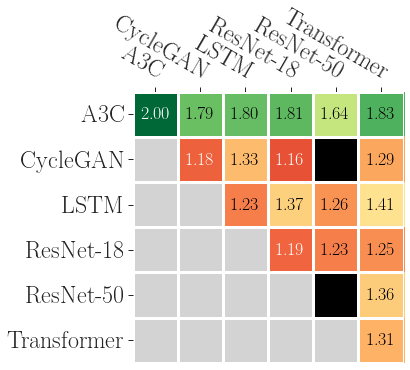

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5.25)
labels = [model_map[model] for model in models]
im = heatmap(throughputs_matrix, labels, labels, ax=ax, vmin=1.0, vmax=2.0)
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()

In [9]:
fig.savefig('heatmap.pdf', dpi=600, bbox_inches='tight')